## LSTM Part-of-Speech Tagger
### Step 1: Importing the <code>torch</code>  and other libraries

In [0]:
#torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

#other stuff
import numpy as np
import glob, os, random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
from timeit import default_timer as timer

### Step 2: Get the helper functions

In [0]:
# Read the data file
def read_data(filepath):
    data = []
    with open(filepath, 'r', encoding="utf8") as f:
        for line in f:
            data.append(tuple(zip(*[wt.split('/') for wt in line.strip().split()])))
    return data

# Get vocabs and tagset
def get_vocab_tagset(data):
    token_size, vocabs, tagset = 0, set(), set()
    for words, tags in data:
        token_size += len(words)
        vocabs.update(words)
        tagset.update(tags)
    return vocabs, tagset, token_size

# convert the sequencies to indexes and tensors
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# indexing list elements: use this for vocabs and tagset
def to_index(aList):
    elem_to_idx = {e:aList.index(e)+1 for e in aList}
    elem_to_idx['Unknown'] = 0  
    idx_to_elem = {i:e for e,i in elem_to_idx.items()}
    return elem_to_idx, idx_to_elem

# import numpy as np
def score_to_tag(tag_scores, i_to_tag):
    tagged=[]
    for preds in tag_scores:
        preds = list(np.array(preds))
        idx = preds.index(max(preds))
        tagged.append(f"{i_to_tag[idx]}")
    return tagged

tagged_data_file = "cy_pos_coarse_tagged"
# tagged_data_file = "cy_sem_coarse_tagged"
# tagged_data_file = "cy_both_coarse_tagged"



### Step 3: Preparing the data

In [57]:
# Read training data for each folder
print(f"\nReading {tagged_data_file} ...", end='')
data = read_data(tagged_data_file)
vocabs, tagset, token_size = get_vocab_tagset(data)
tagset = set(t for t in tagset if t) #Just taking care of some null string in tagset

# #Uncomment below for data statistics
# print(f"\nSentences:\t{len(training_data)}\nToken size:\t{token_size}\nVocab size:\t{len(vocabs)}\nTagset size:\t{len(tagset)}")

# Shuffle and split data
random.seed(7)
random.shuffle(data)
test_size = 0.1 #90% of data for training; 10% of data for testing
train_set, test_set = data[:-int(len(data)*test_size)], data[-int(len(data)*test_size):]

EMBEDDING_DIM = 100
HIDDEN_DIM = 5    
word_to_idx, idx_to_word = to_index(list(vocabs))
tag_to_idx, idx_to_tag = to_index(list(tagset))


Reading cy_pos_coarse_tagged ...

### Step 4: Creating the model

In [0]:
class Tagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(Tagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

### Step 5: Training the model

In [91]:
model = Tagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_idx), len(tag_to_idx))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

start = timer()

NUM_EPOCHS = 500
result_point = 50

ACC, PRE, REC, F1 = [],[],[],[]
print(f"{' '*(NUM_EPOCHS//result_point+8)}\tACC\tPRE\tREC\tF1\n[{'.'*max((NUM_EPOCHS//result_point)-1,1)}", end='')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for epoch in range(NUM_EPOCHS):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in train_set:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_idx)
            targets = prepare_sequence(tags, tag_to_idx)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)
            
            
            loss.backward()
            optimizer.step()

        y_gold, y_pred = [],[]
        with torch.no_grad():
            for sent in test_set:
                y_gold.extend(sent[1])
                inputs = prepare_sequence(sent[0], word_to_idx)
                tag_scores = model(inputs)
                y_pred.extend(score_to_tag(tag_scores, idx_to_tag))

            acc=accuracy_score(y_gold, y_pred)*100
            pre=precision_score(y_gold, y_pred, average='macro')*100
            rec=recall_score(y_gold, y_pred, average='macro')*100
            f1=f1_score(y_gold, y_pred, average='macro')*100

            ACC.append(acc)
            PRE.append(pre)
            REC.append(rec)
            F1.append(f1)
#             _gold = prepare_sequence(y_gold, tag_to_idx)
#             _pred = prepare_sequence(y_pred, tag_to_idx)
#             _loss = loss_function(_gold, _pred)
            
            if epoch%max(NUM_EPOCHS//result_point,1)==0:
                print(f"] Epoch {epoch:003d}: {acc:.2f}",end='\t')
                print(f"{pre:.2f}",end='\t')
                print(f"{rec:.2f}",end='\t')
                print(f"{f1:.2f}\n[", end='')
            elif epoch == NUM_EPOCHS-1:
                print(f".] Epoch {epoch:003d}: {acc:.2f}\t{pre:.2f}\t{rec:.2f}\t{f1:.2f}")
            else:
                print('.',end='')
                    
print(f'Done! Total time: {timer() - start:.2f} secs')

#plot y_gold, y_pred for accuracy, precision and F1

                  	ACC	PRE	REC	F1
[.........] Epoch 000: 44.65	18.42	21.68	18.38
[.........] Epoch 010: 60.70	38.28	35.82	35.88
[.........] Epoch 020: 67.11	41.34	42.25	41.33
[.........] Epoch 030: 70.59	53.92	47.99	48.17
[.........] Epoch 040: 71.86	53.05	50.28	50.59
[.........] Epoch 050: 72.39	54.36	50.82	51.10
[.........] Epoch 060: 72.66	53.71	50.89	51.14
[.........] Epoch 070: 73.53	54.07	51.45	51.76
[.........] Epoch 080: 74.73	55.73	53.64	54.12
[.........] Epoch 090: 74.67	56.39	55.62	55.49
[.........] Epoch 100: 74.87	56.00	55.99	55.60
[.........] Epoch 110: 75.47	57.31	56.89	56.74
[.........] Epoch 120: 74.06	54.40	53.14	53.20
[.........] Epoch 130: 74.73	57.42	56.59	56.71
[.........] Epoch 140: 75.33	57.94	57.29	57.29
[.........] Epoch 150: 74.87	57.42	56.51	56.58
[.........] Epoch 160: 74.80	55.97	56.73	56.07
[.........] Epoch 170: 75.47	56.52	56.96	56.50
[.........] Epoch 180: 75.33	56.35	56.70	56.36
[.........] Epoch 190: 75.20	55.50	56.67	55.78
[.........] Epoch 200: 75.

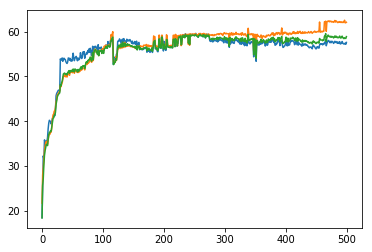

In [94]:
import numpy as np
import matplotlib.pyplot as plt
# plt.plot(ACC)
plt.plot(PRE)
plt.plot(REC)
plt.plot(F1)
plt.show()